# Bollinger Bands Strategy

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
GLDdf = pd.read_csv('data/GLD_history.csv', skiprows=1)
GLDdf.columns = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']
GLDdf['Date'] = pd.to_datetime(GLDdf['Date'], errors='coerce')
GLDdf['Close'] = pd.to_numeric(GLDdf['Close'], errors='coerce')

USOdf = pd.read_csv('data/USO_history.csv', skiprows=1)
USOdf.columns = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']
USOdf['Date'] = pd.to_datetime(USOdf['Date'], errors='coerce')
USOdf['Close'] = pd.to_numeric(USOdf['Close'], errors='coerce')

## Data Statistics & Test Signals

In [3]:
window = 20
entryZscore = 1
exitZscore = 0

GLDdf['Ratio'] = GLDdf['Close'] / USOdf['Close']
mean = GLDdf['Ratio'].rolling(window=window).mean()
std = GLDdf['Ratio'].rolling(window=window).std()
GLDdf['Z_Score'] = (GLDdf['Ratio'] - mean) / std

# Entry & Exit Signals
GLDdf['Long_Entry'] = np.where(GLDdf['Z_Score'] < -entryZscore, 1, 0)
GLDdf['Long_Exit'] = np.where(GLDdf['Z_Score'] >= -exitZscore, 1, 0)
GLDdf['Short_Entry'] = np.where(GLDdf['Z_Score'] > entryZscore, -1, 0)
GLDdf['Short_Exit'] = np.where(GLDdf['Z_Score'] <= exitZscore, -1, 0)

GLDdf['NumUnitsLong'] = np.nan
GLDdf.loc[GLDdf['Long_Entry'] == 1, 'NumUnitsLong'] = 1
GLDdf.loc[GLDdf['Long_Exit'] == 1, 'NumUnitsLong'] = 0
GLDdf['NumUnitsLong'].ffill(inplace=True)

GLDdf['NumUnitsShort'] = np.nan
GLDdf.loc[GLDdf['Short_Entry'] == -1, 'NumUnitsShort'] = -1
GLDdf.loc[GLDdf['Short_Exit'] == -1, 'NumUnitsShort'] = 0
GLDdf['NumUnitsShort'].ffill(inplace=True)

# Combining long and short to get net units
GLDdf['NumUnits'] = GLDdf['NumUnitsLong'] + GLDdf['NumUnitsShort']

## Bollinger Bands Returns and Statistics

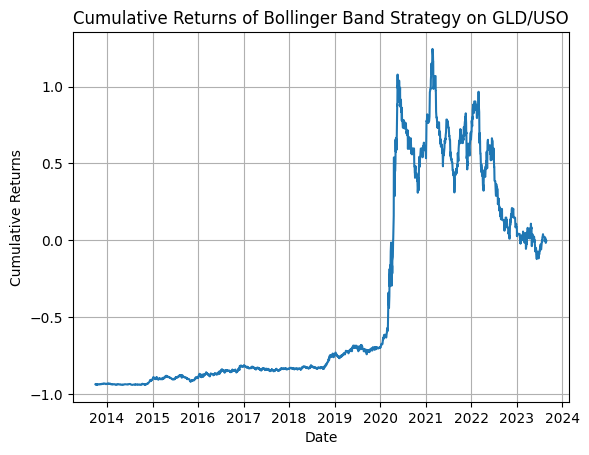

Sharpe Ratio: -0.043572958410655845
APR: -18.65%


In [4]:
# Returns
GLDdf['Return'] = GLDdf['Ratio'].pct_change() * GLDdf['NumUnits'].shift(1)
GLDdf['CumulativeReturn'] = (1 + GLDdf['Return']).cumprod() - 1

# Plot Cumulative Returns
plt.plot(GLDdf['Date'], GLDdf['CumulativeReturn'])
plt.title('Cumulative Returns of Bollinger Band Strategy on GLD/USO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# Sharpe Ratio and APR 
risk_free_rate_annual = 0.053  # 3 month t bill rate
risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1/252) - 1
average_daily_return = GLDdf['Return'].mean()
std_dev_return = GLDdf['Return'].std()
sharpe_ratio = (average_daily_return - risk_free_rate_daily) / std_dev_return
apr = (1 + average_daily_return) ** 252 - 1

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"APR: {apr * 100:.2f}%")